# Data Analysis

As described in the introduction, I want to assign each area of London to a borough of Frankfurt. 

I got all the location data I need to obtain all the areas/boroughs of both cities and I fetched all the venues with their specific coordinates, category and name.

First step of the analysis will be the calculation and exploration of the venues across the different areas/boroughs. Here I will use a heat map to compare areas/boroughs of both cities with a high number of venues.

In the second and final step I will focus on classifying the areas of London. I will have to prepare the features for the logistic regression model and I need to train it. I will present a map of London with markers labeling the different areas and which borough of Frankfurt fit best.

Please use https://nbviewer.jupyter.org/ to see folium maps in github.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

# sort dictonary values
import operator

# library to handle JSON files
import json 

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

# library to handle requests
import requests 

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

# for classification
from sklearn.linear_model import LogisticRegression

# for scaling the data
from sklearn.preprocessing import StandardScaler

#!conda install -c conda-forge folium=0.5.0 --yes
# map rendering library
import folium 

# creating heatmaps
from folium import plugins
from folium.plugins import HeatMap

## Importing the datasets

In [2]:
df_l = pd.read_csv("london_areas_latlong.csv")
df_f = pd.read_csv("frankfurt_boroughs_latlong.csv")
df_l.head()

,Area,Latitude,Longitude
0,Abbey Wood,51.487621,0.114050
1,Acton,51.508140,-0.273261
2,Addington,51.358636,-0.031635
3,Addiscombe,51.379692,-0.074282
4,Albany Park,51.435384,0.125965


In [3]:
df_l.isna().any()
#df_l.dropna(inplace=True)
df_l.shape

(522, 3)

## Creating a Map of London and Frankfurt

Now let's visualize the areas we are going to explore.

### London

In [4]:
address = 'London, England, Great Britain'

geolocator = Nominatim(user_agent="l_explorer")
location = geolocator.geocode(address)
latitude_l = location.latitude
longitude_l = location.longitude
print(f'The geograpical coordinate of London are {latitude_l}, {longitude_l}.')

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [5]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude_l, longitude_l], zoom_start=10)

# add markers to map
for lat, lng, area in zip(df_l['Latitude'], df_l['Longitude'], df_l['Area']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

### Frankfurt

In [6]:
address = 'Frankfurt, Hessen, Germany'

geolocator = Nominatim(user_agent="f_explorer")
location = geolocator.geocode(address)
latitude_f = location.latitude
longitude_f = location.longitude
print(f'The geograpical coordinate of Frankfurt are {latitude_f}, {longitude_f}.')

The geograpical coordinate of Frankfurt are 50.1106444, 8.6820917.


In [7]:
# create map of Frankfurt using latitude and longitude values
map_frankfurt = folium.Map(location=[latitude_f, longitude_f], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(df_f['Latitude'], df_f['Longitude'], df_f['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_frankfurt)  
    
map_frankfurt

## Defining the areas we want to explore

Our neighborhoods will be defined as circular areas with a radius of 500 meters. We are interested in the venues in those areas, but first let' visualize the areas and their radius.

### London

In [55]:
# map of areas we are going to explore. The radius is 500m from the center of the area
map_london = folium.Map(location=[latitude_l, longitude_l], zoom_start=10)

# add markers to map
for lat, lng, area in zip(df_l['Latitude'], df_l['Longitude'], df_l['Area']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=500,
        popup=label,
        color='green',
        fill=True,
        fill_color='#CAFF70',
        fill_opacity=0.3,
        parse_html=False).add_to(map_london)  
    
map_london

### Frankfurt

In [56]:
# create map of Frankfurt using latitude and longitude values
map_frankfurt = folium.Map(location=[latitude_f, longitude_f], zoom_start=10)

# add markers to map
for lat, lng, area in zip(df_f['Latitude'], df_f['Longitude'], df_f['Borough']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=500,
        popup=label,
        color='green',
        fill=True,
        fill_color='#CAFF70',
        fill_opacity=0.3,
        parse_html=False).add_to(map_frankfurt)  
    
map_frankfurt

## Venue Data

Now we are goign to use the foursquare API to fetch data about the top 100 venues of every area. First we need to define the credentials we need to get access to the foursquare API.

In [10]:
CLIENT_ID = 'G0EDQTSKXYGO4PAYI14O2I0FUVWOU1ZSADJKFIFZAJDW3DB0'
CLIENT_SECRET = 'GZT4BQDW1Z0DFAM1RY3SQ1QPN4UIDPBFQBXVJC00YJ02FABI'
VERSION = '20180604' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: G0EDQTSKXYGO4PAYI14O2I0FUVWOU1ZSADJKFIFZAJDW3DB0
CLIENT_SECRET:GZT4BQDW1Z0DFAM1RY3SQ1QPN4UIDPBFQBXVJC00YJ02FABI


In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print("ERROR:",requests.get(url).json())
            return 

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Getting the venues for Frankfurt

In [13]:
frankfurt_venues = getNearbyVenues(names=df_f['Borough'],
                                   latitudes=df_f['Latitude'],
                                   longitudes=df_f['Longitude'],
                                   radius=500  
                                  )

In [15]:
print(frankfurt_venues.shape)
frankfurt_venues.head()

(805, 7)


,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Altstadt,50.110442,8.682901,Römerberg,50.110489,8.682131,Plaza
1,Altstadt,50.110442,8.682901,SCHIRN Kunsthalle,50.110291,8.683542,Art Museum
2,Altstadt,50.110442,8.682901,Dom Aussichtsplattform,50.110609,8.684908,Scenic Lookout
3,Altstadt,50.110442,8.682901,Weinterasse Rollanderhof,50.112473,8.682164,Wine Bar
4,Altstadt,50.110442,8.682901,Main,50.108390,8.682631,River


### Number of Venues per area

In [16]:
frankfurt_distrib = frankfurt_venues.groupby('Area').count()
frankfurt_distrib.drop(frankfurt_distrib.columns.difference(['Area Latitude']), 1, inplace=True)
frankfurt_distrib.columns = ['Distribution']
frankfurt_distrib.mean()

Distribution    17.5
dtype: float64

In [17]:
frankfurt_distrib.head()

,Distribution
Area,
Altstadt,94
Bahnhofsviertel,100
Berkersheim,2
Bockenheim,28
Bonames,8


Text(0.5, 0, 'Number of Venues')

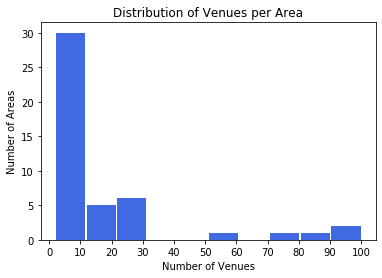

In [18]:
frankfurt_distrib["Distribution"].plot(kind="hist", rwidth=.95, color="royalblue")
plt.xticks([10 * i for i in range(11)])
plt.title("Distribution of Venues per Area")
plt.ylabel("Number of Areas")
plt.xlabel("Number of Venues")

## Distribution of the venues in Frankfurt

In [19]:

map_frankfurt_heat = folium.Map(location=[latitude_f, longitude_f], zoom_start = 11) 

# Ensure you're handing it floats
frankfurt_venues['Venue Latitude'] = frankfurt_venues['Venue Latitude'].astype(float)
frankfurt_venues['Venue Longitude'] = frankfurt_venues['Venue Longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = frankfurt_venues[['Venue Latitude', 'Venue Longitude']]
heat_df = heat_df.dropna(axis=0, subset=['Venue Latitude','Venue Longitude'])

# List comprehension to make out list of lists
heat_data = [[row['Venue Latitude'],row['Venue Longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data, radius=15).add_to(map_frankfurt_heat)

# Display the map
map_frankfurt_heat

## Location of the venues in "Bahnhofsviertel"

In [20]:
bhvrtl_venues = frankfurt_venues.loc[frankfurt_venues['Area'] == "Bahnhofsviertel"]

In [21]:
# create map of Frankfurt using latitude and longitude values
latitude_bhvrtl = 50.107741
longitude_bhvrtl = 8.668676
map_bhvrtl = folium.Map(location=[latitude_bhvrtl, longitude_bhvrtl], zoom_start=15)

# add borough radius to the map
folium.Circle(
    [latitude_bhvrtl, longitude_bhvrtl],
    radius=500,
    popup=label,
    color='green',
    fill=True,
    fill_color='#CAFF70',
    fill_opacity=0.3,
    parse_html=False).add_to(map_bhvrtl)  

# add venue markers to map
for lat, lng, cat, name in zip(bhvrtl_venues['Venue Latitude'], bhvrtl_venues['Venue Longitude'], bhvrtl_venues['Venue Category'], bhvrtl_venues['Venue']):
    #label = '{}'.format(area)
    label = folium.Popup(name + ' Category ' + cat, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#FF0000',
        fill_opacity=0.3,
        parse_html=False).add_to(map_bhvrtl)
    

    
map_bhvrtl

### Insights about the venues

Let's check out how many different venue categories we have.

In [22]:
print('There are {} uniques categories.'.format(len(frankfurt_venues['Venue Category'].unique())))

There are 185 uniques categories.


### Analysing each area

In [23]:
# one hot encoding
frankfurt_onehot = pd.get_dummies(frankfurt_venues[['Venue Category']], prefix="", prefix_sep="")

# add area column back to dataframe
frankfurt_onehot['Area'] = frankfurt_venues['Area'] 

# move frankfrtt column to the first column
fixed_columns = [frankfurt_onehot.columns[-1]] + list(frankfurt_onehot.columns[:-1])
frankfurt_onehot = frankfurt_onehot[fixed_columns]

frankfurt_onehot.head()

,Area,ATM,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Apple Wine Pub,Art Gallery,Art Museum,Asian Restaurant,...,Train Station,Tram Station,Transportation Service,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar
0,Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Altstadt,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Checkout the new size.

In [24]:
frankfurt_onehot.shape

(805, 186)

### Top 10 venues per city

In [25]:
def get_top_10_venues_city(df):
    df_copy = df.copy()
    dicti = {}
    df_copy.drop(columns="Area", inplace=True)
    
    for element in df_copy.columns:
        dicti.update( {element : df_copy[element].sum()})
    
    sorted_d = dict( sorted(dicti.items(), key=operator.itemgetter(1),reverse=True))
    #print(sorted_d.items())
    #print('Dictionary in descending order by value : ',sorted_d)
    items = list(sorted_d.items())
    top_10 = []
    for i in range(10):
        top_10.append(items[i])
    
    df_res = pd.DataFrame(top_10, columns=['Venue', 'Number of occurrences'])
    df_res.set_index('Venue', inplace=True)
    return df_res

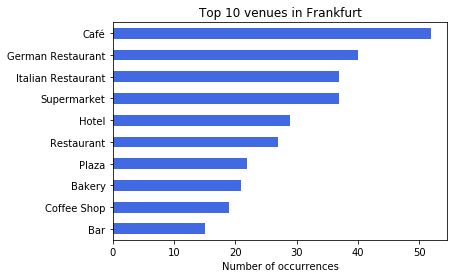

In [26]:
top_10_venues_frankfurt = get_top_10_venues_city(frankfurt_onehot)

top_10_venues_frankfurt.plot(kind="barh", color="royalblue")
plt.title("Top 10 venues in Frankfurt")
plt.xlabel("Number of occurrences")
plt.ylabel("")
plt.legend().remove()
plt.gca().invert_yaxis()
plt.show()

### Top 10 venues per area

Next, we group the rows by area and by taking the mean of the frequency of occurence of each category.

In [59]:
frankfurt_grouped = frankfurt_onehot.groupby('Area').mean().reset_index()
frankfurt_grouped.head()

,Area,ATM,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Apple Wine Pub,Art Gallery,Art Museum,Asian Restaurant,...,Train Station,Tram Station,Transportation Service,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar
0,Altstadt,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.042553,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.010638,0.010638,0.00,0.00,0.021277
1,Bahnhofsviertel,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.010000,0.010000,...,0.0,0.0,0.0,0.0,0.000000,0.010000,0.030000,0.01,0.01,0.010000
2,Berkersheim,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000
3,Bockenheim,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.107143,...,0.0,0.0,0.0,0.0,0.035714,0.000000,0.000000,0.00,0.00,0.035714
4,Bonames,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.000000


Let's print each area with the top 5 most common venues.

In [60]:
num_top_venues = 5

for hood in frankfurt_grouped['Area']:
    # print("----"+hood+"----")
    temp = frankfurt_grouped[frankfurt_grouped['Area'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    # print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    # print('\n')

Let's safe this in a dataframe and start with a function to sort the venues in a descending order

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighbourhood

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = frankfurt_grouped['Area']

for ind in np.arange(frankfurt_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(frankfurt_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Altstadt,Café,Plaza,Restaurant,German Restaurant,Art Museum,Burger Joint,Coffee Shop,Bar,History Museum,Italian Restaurant
1,Bahnhofsviertel,Hotel,Indian Restaurant,Bar,Bakery,Restaurant,Café,Chinese Restaurant,Seafood Restaurant,Vietnamese Restaurant,Mexican Restaurant
2,Berkersheim,Construction & Landscaping,German Restaurant,Wine Bar,Event Space,French Restaurant,Fountain,Food Court,Food & Drink Shop,Food,Farmers Market
3,Bockenheim,Café,Asian Restaurant,Ice Cream Shop,Middle Eastern Restaurant,Wine Bar,Tapas Restaurant,Gym,Greek Restaurant,Optical Shop,Department Store
4,Bonames,Ice Cream Shop,Italian Restaurant,Doner Restaurant,Café,Metro Station,German Restaurant,Bakery,Diner,History Museum,Historic Site


### Getting the venues for London

In [31]:
london_venues = getNearbyVenues(names=df_l['Area'],
                                   latitudes=df_l['Latitude'],
                                   longitudes=df_l['Longitude'],
                                   radius=500  
                                  )

In [33]:
print(london_venues.shape)
london_venues.head()

(12557, 7)


,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.487621,0.114050,Co-op Food,51.487650,0.113490,Grocery Store
1,Abbey Wood,51.487621,0.114050,Thind Wine Merchants,51.487503,0.112782,Wine Shop
2,Abbey Wood,51.487621,0.114050,Bostal Gardens,51.486670,0.110462,Playground
3,Abbey Wood,51.487621,0.114050,Abbey Wood Caravan Club,51.485502,0.120014,Campground
4,Acton,51.508140,-0.273261,London Star Hotel,51.509624,-0.272456,Hotel


## Number of venues per area

In [34]:
london_distrib = london_venues.groupby('Area').count()
london_distrib.drop(london_distrib.columns.difference(['Area Latitude']), 1, inplace=True)
london_distrib.columns = ['Distribution']
london_distrib.mean()

Distribution    24.241313
dtype: float64

Text(0.5, 0, 'Number of Venues')

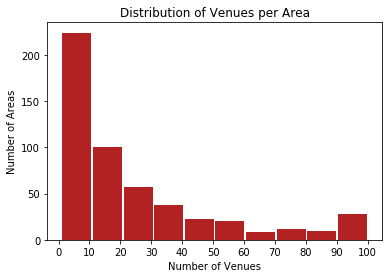

In [35]:
london_distrib["Distribution"].plot(kind="hist", rwidth=.95, color="firebrick")
plt.xticks([10 * i for i in range(11)])
plt.title("Distribution of Venues per Area")
plt.ylabel("Number of Areas")
plt.xlabel("Number of Venues")

## Heatmap of venue distribution in London

In [36]:

map_london_heat = folium.Map(location=[latitude_l, longitude_l], zoom_start = 11) 

# Ensure you're handing it floats
london_venues['Venue Latitude'] = london_venues['Venue Latitude'].astype(float)
london_venues['Venue Longitude'] = london_venues['Venue Longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
#heat_df = df_acc[df_acc['Speed_limit']=='40'] # Reducing data size so it runs faster
#heat_df = df_acc[df_acc['Year']=='2007'] # Reducing data size so it runs faster
heat_df = london_venues[['Venue Latitude', 'Venue Longitude']]
heat_df = heat_df.dropna(axis=0, subset=['Venue Latitude','Venue Longitude'])

# List comprehension to make out list of lists
heat_data = [[row['Venue Latitude'],row['Venue Longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data, radius=12).add_to(map_london_heat)

# Display the map
map_london_heat

### Insights about the venues

In [37]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 409 uniques categories.


### Analyzing each area

In [38]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add area column back to dataframe
london_onehot['Area'] = london_venues['Area'] 

# move london column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,Area,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Abbey Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Abbey Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,Abbey Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Abbey Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Acton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Checkout the new size

In [39]:
london_onehot.shape

(12557, 410)

### Top 10 venues of London

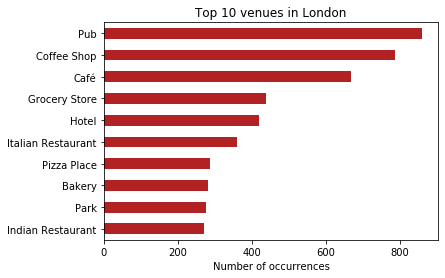

In [40]:
top_10_venues_london = get_top_10_venues_city(london_onehot)

top_10_venues_london.plot(kind="barh", color="firebrick")
plt.title("Top 10 venues in London")
plt.xlabel("Number of occurrences")
plt.ylabel("")
plt.legend().remove()
plt.gca().invert_yaxis()
plt.show()

### Top 10 venues per area

Next, we group the rows by area and by taking the mean of the frequency of occurence of each category.

In [61]:
london_grouped = london_onehot.groupby('Area').mean().reset_index()
london_grouped.head()

,Area,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Abbey Wood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0
1,Acton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.045455,0.0,0.0,0.0,0.0,0.0,0.0
2,Addington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Addiscombe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,Albany Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Let's print each area with the top 5 most common venues.

In [62]:
num_top_venues = 5

for hood in london_grouped['Area']:
    # print("----"+hood+"----")
    temp = london_grouped[london_grouped['Area'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    # print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    # print('\n')

Now let's create the new dataframe and display the top 10 venues for each neighbourhood

In [43]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_l = pd.DataFrame(columns=columns) # changed variable to ""_l 
neighborhoods_venues_sorted_l['Area'] = london_grouped['Area']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted_l.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_l.head()
#########################################################################################################
# Bug with assigning everything:
# neighborhoods_venues_sorted_l.loc[neighborhoods_venues_sorted_l['Area'] == "Coombe"] NOT WORKING NaN.

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Grocery Store,Wine Shop,Playground,Campground,Zoo Exhibit,Filipino Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant
1,Acton,Pub,Gym / Fitness Center,Creperie,Coffee Shop,Cocktail Bar,Sandwich Place,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Pool
2,Addington,English Restaurant,Tram Station,Gas Station,Bus Station,Zoo Exhibit,Film Studio,Event Space,Exhibit,Falafel Restaurant,Farm
3,Addiscombe,Bakery,Grocery Store,Park,Café,Chinese Restaurant,Fast Food Restaurant,Diner,Food,Flower Shop,Event Space
4,Albany Park,Pub,Train Station,Indian Restaurant,Grocery Store,Filipino Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant


## Adjust the data

We have to adjust the data so that the Frankfurt and London datasets have the same features

In [44]:
# Adding unique ids for  each area of frankfurt
numbers = [x for x in range(frankfurt_grouped.shape[0])]    # 0 - 45
frankfurt_grouped.insert(0, 'Numerical Labels', numbers)

y_dict = pd.Series(frankfurt_grouped["Numerical Labels"].values,index=frankfurt_grouped.Area.values).to_dict()
frankfurt_grouped.drop(columns="Numerical Labels", inplace = True)
# y_dict    # uncomment  to check the dictionary

At first we have to drop or rename all columns of the frankfurt dataset who are not part of the london dataset. Then we drop all columns of the london dataset, if they are not in the frankfurt dataset.

In [45]:

missing_categories = []

for category in frankfurt_grouped.columns:
    if category in london_grouped.columns:
        continue
    elif ((category not in london_grouped.columns) & (category == "Airport Lounge")):
        frankfurt_grouped.rename(columns={category: "Airport Terminal"}, inplace=True)
    elif ((category not in london_grouped.columns) & (category == "Airport Service")):
        frankfurt_grouped.drop(columns="Airport Service", inplace = True)
    else:
        frankfurt_grouped.drop(columns=category, inplace = True)
        missing_categories.append(category)
        # print(category, "is not in london_grouped")    # uncheck to show the categories which are not part of london_grouped

In [46]:
# 46 areas and 163 categories
frankfurt_grouped.shape

(46, 164)

In [47]:
for category in london_grouped.columns:
    if category in frankfurt_grouped.columns:
        continue
    else:
        london_grouped.drop(columns=category, inplace = True)
        #print(category, "is not in frankfurt_grouped")

In [48]:
# 518 areas and 163 categories
london_grouped.shape

(518, 164)

We have to reindex the columns because we changed the names of a couple columns and we want the same order in both datasets.

In [49]:
frankfurt_grouped = frankfurt_grouped.reindex(sorted(frankfurt_grouped.columns), axis=1)
london_grouped = london_grouped.reindex(sorted(london_grouped.columns), axis=1)

## Classification

In [50]:
X = frankfurt_grouped.drop(columns=["Area"])
y = frankfurt_grouped.drop(frankfurt_grouped.columns.difference(["Area"]), 1)

X_test = london_grouped.drop(columns=["Area"])

In [51]:
model = LogisticRegression()
model.fit(X, y)

labels = model.predict(X_test)
len(labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


518

In [52]:
# add classification labels
neighborhoods_venues_sorted_l.insert(0, 'Classification Labels', labels)

london_merged = df_l

# merge london_grouped with london_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(neighborhoods_venues_sorted_l.set_index('Area'), on='Area')

print(london_merged.isnull().sum())

print("Before deleting NaNs:", london_merged.shape)

#########################################################################
#only neccessary if # neighborhoods_venues_sorted_l.loc[neighborhoods_venues_sorted_l['Area'] == "Coombe"] NOT WORKING NaN.
# is not fixed. Deleting the rows where the data is NaN.
london_merged.dropna(inplace=True)
print("After deleting NaNs:", london_merged.shape)

# adding the Numerical Labels for future usage.
london_num_labels = []
for i, element in enumerate(london_merged["Classification Labels"]):
    
# identifying the NaN object for further bug analysis
#    if(element != element):
#        print(i, "-------", element)
#    else:
#        print (i, element, y_dict[element])
    if(element != element):
        london_num_labels.append(9999)
    else:
        london_num_labels.append(y_dict[element])
    
london_merged.insert(0, 'Numerical Labels', london_num_labels)


london_merged.head() 

Area                      0
Latitude                  0
Longitude                 0
Classification Labels     4
1st Most Common Venue     4
2nd Most Common Venue     4
3rd Most Common Venue     4
4th Most Common Venue     4
5th Most Common Venue     4
6th Most Common Venue     4
7th Most Common Venue     4
8th Most Common Venue     4
9th Most Common Venue     4
10th Most Common Venue    4
dtype: int64
Before deleting NaNs: (522, 14)
After deleting NaNs: (518, 14)


,Numerical Labels,Area,Latitude,Longitude,Classification Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,34,Abbey Wood,51.487621,0.114050,Rödelheim,Grocery Store,Wine Shop,Playground,Campground,Zoo Exhibit,Filipino Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant
1,7,Acton,51.508140,-0.273261,Eckenheim,Pub,Gym / Fitness Center,Creperie,Coffee Shop,Cocktail Bar,Sandwich Place,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Pool
2,14,Addington,51.358636,-0.031635,Griesheim,English Restaurant,Tram Station,Gas Station,Bus Station,Zoo Exhibit,Film Studio,Event Space,Exhibit,Falafel Restaurant,Farm
3,8,Addiscombe,51.379692,-0.074282,Eschersheim,Bakery,Grocery Store,Park,Café,Chinese Restaurant,Fast Food Restaurant,Diner,Food,Flower Shop,Event Space
4,34,Albany Park,51.435384,0.125965,Rödelheim,Pub,Train Station,Indian Restaurant,Grocery Store,Filipino Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant


In [64]:
# create map
kclusters = 46 ######################## should be 46 (for each boroguh in Frankfurt)

map_clusters_l = folium.Map(location=[latitude_l, longitude_l], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, clas, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Area'], london_merged['Classification Labels'], london_merged['Numerical Labels']):
    label = folium.Popup(str(poi) + ' Frankfurt: ' + str(clas), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters_l)
       
map_clusters_l